## Model Benchmarking

In the previous section, we already select some models to be tested using the real test data we haven't see before. In this section we will evaluate the model and translate back into our businees needs. We will go through the overall evaluation metrics as well as the brier score loss and see how can this model solve our initial problem.

In [1]:
import pandas as pd
import numpy as np
import shap
# print the JS visualization code to the notebook
shap.initjs()

import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import pickle
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve, brier_score_loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
lr = pickle.load(open('estimator_lr.sav', 'rb'))
lr_iso = pickle.load(open('estimator_lr_iso.sav', 'rb'))
lr_sig = pickle.load(open('estimator_lr_sig.sav', 'rb'))
lgbm = pickle.load(open('estimator_lgbm.sav', 'rb'))
lgbm_iso = pickle.load(open('estimator_lgbm_iso.sav', 'rb'))
lgbm_sig = pickle.load(open('estimator_lgbm_sig.sav', 'rb'))

In [3]:
df = pd.read_csv('./archive/train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df['Region_Code'] = df['Region_Code'].apply(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(str)

In [5]:
X = df.drop(['id', 'Response'], axis=1)
y = df['Response']

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.3,
                                                            random_state=2021)

> ### Model Testing

In [7]:
def test_model(model='lr'):
    if model == 'lr':
        model = lr
    elif model == 'lr_iso':
        model = lr_iso
    elif model == 'lr_sig':
        model = lr_sig
    elif model == 'lgbm':
        model = lgbm
    elif model == 'lgbm_iso':
        model = lgbm_iso
    elif model == 'lgbm_sig':
        model = lgbm_sig
        
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    brier_loss = brier_score_loss(y_test, y_pred_proba, pos_label=y_pred.max())
    print(classification_report(y_test, y_pred))
    print(f'Brier score loss: {brier_loss}')
    plot_precision_recall_curve(model, X_test, y_test)
    plot_confusion_matrix(model, X_test, y_test);

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100320
           1       0.28      0.93      0.43     14013

    accuracy                           0.69    114333
   macro avg       0.63      0.79      0.61    114333
weighted avg       0.90      0.69      0.75    114333

Brier score loss: 0.17568413321724546


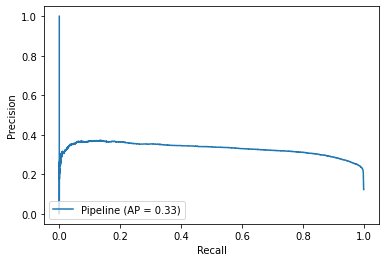

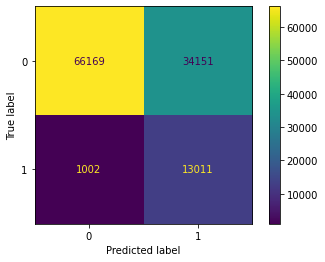

In [8]:
test_model('lr')

              precision    recall  f1-score   support

           0       0.98      0.67      0.80    100320
           1       0.28      0.92      0.43     14013

    accuracy                           0.70    114333
   macro avg       0.63      0.79      0.61    114333
weighted avg       0.90      0.70      0.75    114333

Brier score loss: 0.17576987572574276


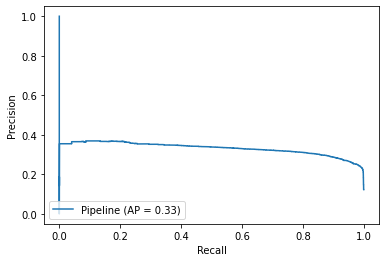

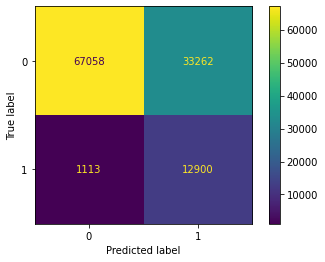

In [9]:
test_model('lr_iso')

              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100320
           1       0.28      0.93      0.43     14013

    accuracy                           0.69    114333
   macro avg       0.63      0.79      0.61    114333
weighted avg       0.90      0.69      0.75    114333

Brier score loss: 0.1757602409837684


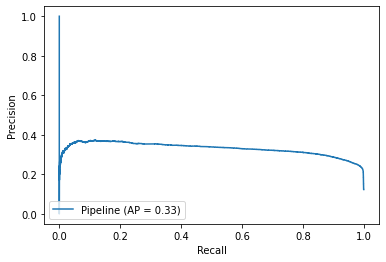

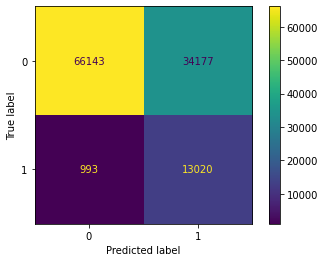

In [10]:
test_model('lr_sig')

              precision    recall  f1-score   support

           0       0.98      0.69      0.81    100320
           1       0.29      0.88      0.43     14013

    accuracy                           0.72    114333
   macro avg       0.63      0.79      0.62    114333
weighted avg       0.89      0.72      0.77    114333

Brier score loss: 0.16111994629658932


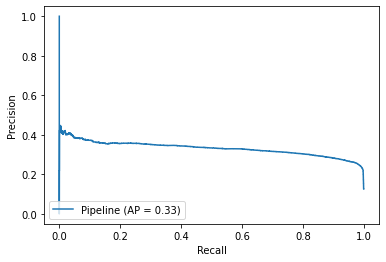

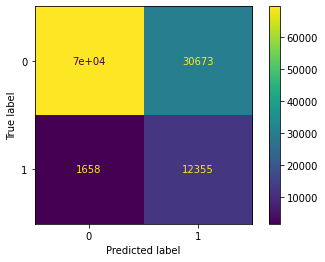

In [11]:
test_model('lgbm')

              precision    recall  f1-score   support

           0       0.97      0.71      0.82    100320
           1       0.29      0.86      0.44     14013

    accuracy                           0.73    114333
   macro avg       0.63      0.78      0.63    114333
weighted avg       0.89      0.73      0.77    114333

Brier score loss: 0.15806521757864228


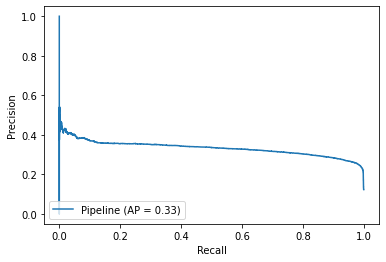

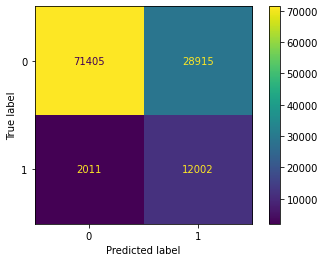

In [12]:
test_model('lgbm_iso')

              precision    recall  f1-score   support

           0       0.97      0.73      0.83    100320
           1       0.30      0.83      0.44     14013

    accuracy                           0.74    114333
   macro avg       0.63      0.78      0.63    114333
weighted avg       0.89      0.74      0.78    114333

Brier score loss: 0.15950811279893143


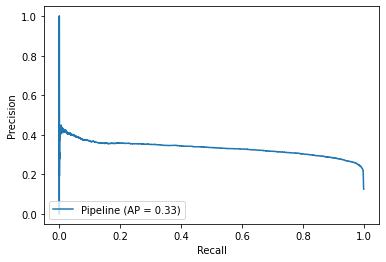

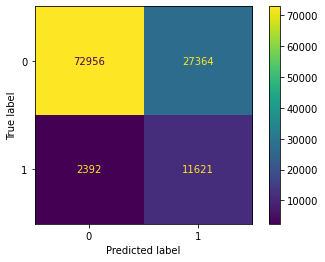

In [13]:
test_model('lgbm_sig')

> ### Threshold adjustment

For cross-selling case, the user usually prefer a model with balance between precision and recall. To overcome this problem, I'd like to try addusting the prediction threshold

In [14]:
precision, recall, thr = precision_recall_curve(y_test, lgbm_iso.predict_proba(X_test)[:,1])
pr_df = pd.DataFrame({
    'precision': precision[:-1],
    'recall': recall[:-1],
    'thr': thr
})

In [15]:
pr_df[(pr_df['precision'] > 0.5) & (pr_df['recall'] > 0.5)].sort_values('recall', ascending=True)

,precision,recall,thr


It looks like we can't do anything to balance the precision and recall value. However we can outsmart the limitation of this model by looking on the probability of the prediction.

## Business Interpretation

Since our business problem focused on both class and probability prediction of the potential customer, I decided to take two models for the consideration:

1. For class prediction, LightGBM model without any callibration is delivering most TP
2. For probability prediction, LightGBM with sigmoid callibration is delivering least brier score loss

Within this section I will interpret the model by extracting the feature importances using a popular libraries called SHAP. SHAP is really helpful to interprets and visualizes a complex model such as tree-based and neural network-based model.

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Census%20income%20classification%20with%20scikit-learn.html

In [16]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == imblearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == imblearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

The above function is extracted from this source : 

https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

With a bit of adjustment

In [17]:
lgbm

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage']),
                                                 ('numerical_prep',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['Age', 'Vintage',
                                                   'Annual_Premium']),
                                                 ('region_psc_pred',
         

In [18]:
features = get_feature_names(lgbm.named_steps['preprocess'])
features.remove('numerical_prep__Annual_Premium')

mod_features = []
for i in features:
    if i == 'numerical_prep__Age':
        i = 'numerical_prep__pc1'
    elif i == 'numerical_prep__Vintage':
        i = 'numerical_prep__pc2'
    
    mod_features.append(i)

In [19]:
mod_features

['one_hot_encoder__x0_Male',
 'one_hot_encoder__x1_< 1 Year',
 'one_hot_encoder__x1_> 2 Years',
 'one_hot_encoder__x2_Yes',
 'numerical_prep__pc1',
 'numerical_prep__pc2',
 'binary__Region_Code_0',
 'binary__Region_Code_1',
 'binary__Region_Code_2',
 'binary__Region_Code_3',
 'binary__Region_Code_4',
 'binary__Region_Code_5',
 'binary__Region_Code_6',
 'binary__Policy_Sales_Channel_0',
 'binary__Policy_Sales_Channel_1',
 'binary__Policy_Sales_Channel_2',
 'binary__Policy_Sales_Channel_3',
 'binary__Policy_Sales_Channel_4',
 'binary__Policy_Sales_Channel_5',
 'binary__Policy_Sales_Channel_6',
 'binary__Policy_Sales_Channel_7',
 'binary__Policy_Sales_Channel_8',
 'Driving_License',
 'Previously_Insured']

In [20]:
X_train_shap = lgbm_iso.named_steps['preprocess'].fit_transform(X_train_val)
X_train_shap = pd.DataFrame(X_train_shap, columns=mod_features)
explainer = shap.TreeExplainer(lgbm.named_steps['clf'])
shap_values = explainer.shap_values(X_train_shap)

> ### Model interpretation using SHAP Force Plot

In [21]:
shap.force_plot(explainer.expected_value[1], shap_values[1][4,:], X_train_shap.iloc[4,:])

The above figure is the example of SHAP force plot. Although the concept behind this algorithm is really comnplex, we can simply understand this plot in this following way:
1. This graph trying to visualize our model output in the train data on the index number 4 (see the argument `X_train_shap.iloc[4,:]`). See that the number `-7.13` is in the bold format. This shows the model raw output before transformed into probability space (0.0 to 1.0)
1. The `base value` (-1.156) is the average of the model's raw output in the training data.
1. The pink and blue bar show the tendency of our model that lead to 1 (pink) or 0 (blue). As the proportion of blue bar is higher than the pink, it means our model will return 0 on the prediction (test with `lgbm.predict(X_train_val)[4]` if you're unsure).
1. There size of each segment in the bar represent the magnitude importance of each features in the data. In above example we can clearly notice `Previously_Insured` has the highest imporances. The `Previously_Insurred` feature is placed on the blue bar. It means as the feature goes high, the model output is tend to be dragged towards 1

In [22]:
X_train_shap.iloc[4,:]

one_hot_encoder__x0_Male          1.000000
one_hot_encoder__x1_< 1 Year      0.000000
one_hot_encoder__x1_> 2 Years     0.000000
one_hot_encoder__x2_Yes           0.000000
numerical_prep__pc1               0.090009
numerical_prep__pc2               0.062117
binary__Region_Code_0             0.000000
binary__Region_Code_1             0.000000
binary__Region_Code_2             0.000000
binary__Region_Code_3             0.000000
binary__Region_Code_4             1.000000
binary__Region_Code_5             0.000000
binary__Region_Code_6             1.000000
binary__Policy_Sales_Channel_0    0.000000
binary__Policy_Sales_Channel_1    0.000000
binary__Policy_Sales_Channel_2    0.000000
binary__Policy_Sales_Channel_3    0.000000
binary__Policy_Sales_Channel_4    0.000000
binary__Policy_Sales_Channel_5    0.000000
binary__Policy_Sales_Channel_6    1.000000
binary__Policy_Sales_Channel_7    0.000000
binary__Policy_Sales_Channel_8    0.000000
Driving_License                   1.000000
Previously_

In [23]:
lgbm.predict(X_train_val)[4], y_train_val[4]

(0, 0)

In [24]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], X_train_shap.iloc[:100,:])

We can also use SHAP's force plot to visualize the output from multiple samples. In above example, I use the first 100 samples in the training data. By using this plot, we can see the how vary each feature contributes to each sample outputs. We could notice the `Previously_Insured` feature is being the major contributor to the model in the first 36 data. After that, the proportion of this feature share quite similar proportion (although `Previously_Insured` is still slightly higher) with `one_hot_encoder__x2_Yes` which is come from one-hot encoding of `Drivind_License` feature.

> ### Model Interpretation using SHAP Summary Plot

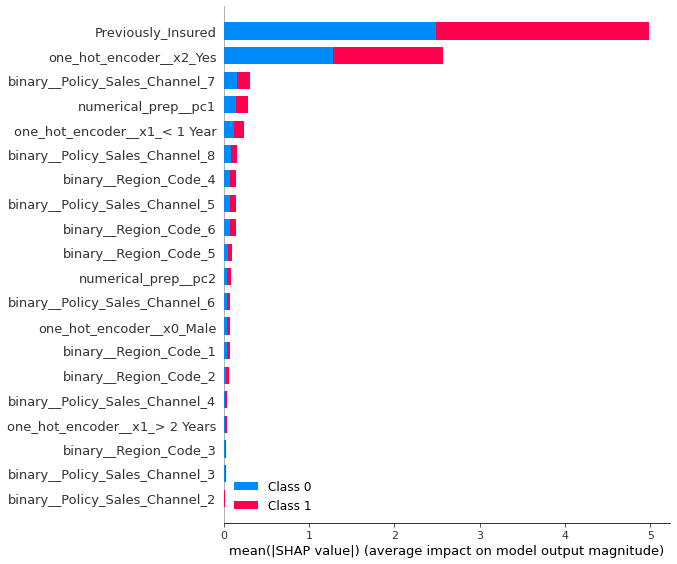

In [25]:
shap.summary_plot(shap_values, X_train_shap)

The summary plot visualize the overall impact of each feature for our model. We can see that `Previously_Insured` is being a major contributor to our model.

> ### Probability Analysis for Marketing Campaign Planning

In [26]:
y_pred = lgbm_iso.predict(X_test)
y_pred_proba = lgbm_iso.predict_proba(X_test)[:,1]

pred_df = pd.DataFrame({
    'predictions': y_pred,
    'predictions_probability': y_pred_proba
})

In [27]:
pred_df

,predictions,predictions_probability
0,1,0.695867
1,1,0.799792
2,0,0.019951
3,1,0.788983
4,0,0.000267
...,...,...
114328,0,0.064558
114329,1,0.796111
114330,0,0.000365
114331,0,0.002393


In [28]:
pred_df['predictions_probability'].describe()

count    114333.000000
mean          0.296969
std           0.334121
min           0.000072
25%           0.000346
50%           0.051775
75%           0.680437
max           0.956003
Name: predictions_probability, dtype: float64

In [29]:
pred_df.groupby(['predictions']).mean()

,predictions_probability
predictions,
0,0.063022
1,0.716733


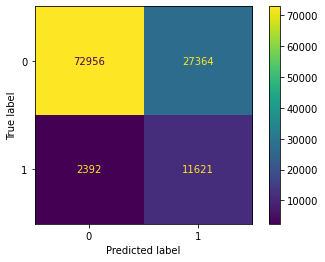

In [30]:
plot_confusion_matrix(lgbm_sig, X_test, y_test);

We realize that our model have so many FPs. The danger of FP is the risk of our customer to cancel the original purchase of our product. So, by looking at the probability, I hope that the marketing team can match what marketing campaign suitable for that kind of customer.

For example if the probability is not high enough (e.g. 0.55), the marketing have to outreach the customer in less persuasive way.

## Prepare The Model for Deployment

In rhe previous section, we have seen that removing the outliers will give better performance for the lgbm model. So, we need to train our final model by using the filtered data like we did before.

In [31]:
filtered_entries = np.array([True] * len(X))

col = 'Annual_Premium'
Q1 = X[col].quantile(0.25)
Q3 = X[col].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

filtered_entries = ((X[col] >= low_limit) & (X[col] <= high_limit)) & filtered_entries

X_filtered, y_filtered = X[filtered_entries], y[filtered_entries]

In [32]:
X_filtered.shape, y_filtered.shape

((370789, 10), (370789,))

In [33]:
lgbm_sig.fit(X_filtered, y_filtered)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage']),
                                                 ('numerical_prep',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['Age', 'Vintage',
                                                   'Annual_Premium']),
                                                 ('region_psc_pred',
         

In [34]:
filename = 'lgbm_final.sav'
pickle.dump(lgbm_iso, open(filename, 'wb'))